In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('data/cars.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6308 entries, 0 to 6307
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   car name         6308 non-null   object
 1   price            6308 non-null   object
 2   engine_capacity  6308 non-null   object
 3   cylinder         5684 non-null   object
 4   horse_power      6308 non-null   object
 5   top_speed        6308 non-null   object
 6   seats            6308 non-null   object
 7   brand            6308 non-null   object
 8   country          6308 non-null   object
dtypes: object(9)
memory usage: 443.7+ KB


In [2]:
import numpy as np
import re

# Function to extract currency and amount from the price string
def extract_currency_and_price(price):
    if isinstance(price, str):
        parts = price.strip().split()
        

        if len(parts) == 2 and len(parts[0]) == 3:
            currency = parts[0]
            try:
                amount = float(parts[1].replace(',', ''))
                return currency, amount
            except ValueError:
                return None, None
        else:
            return None, None
    else:
        return None, None
    
# Data Cleaning: Standardize the 'seats' column
def standardize_seats(seat_value):
    # Check if the seat_value matches the "_ Seater" format
    if isinstance(seat_value, str) and re.match(r'^\d+ Seater$', seat_value):
        # Extract the number of seats
        return int(seat_value.split()[0])
    else:
        return np.nan

# Function to find the nearest value in [4, 6, 8, 12]
def adjust_to_nearest(value, options=[4, 6, 8, 12]):
    return min(options, key=lambda x: abs(x - value))


# Define conversion function with >1000 check for cc values
def convert_to_liters(value):
    if pd.isna(value):
        return np.nan
    
    if value > 1000: 
        return round(value / 1000, 1)
    else:
        return round(value, 1)


# Calculate the mean of 'num_seats', cast it to an integer & fill missing values
df['num_seats'] = df['seats'].apply(lambda x: pd.Series(standardize_seats(x))).astype('Int64')
mean_seats = int(df['num_seats'].mean())
df['num_seats'] = df['num_seats'].fillna(mean_seats)

# Convert 'top_speed' to numeric, setting non-numeric values to mean value
df['top_speed'] = pd.to_numeric(df['top_speed'], errors='coerce')
mean_top_speed = int(df['top_speed'].mean())
df['top_speed'] = df['top_speed'].fillna(mean_top_speed).astype('Int64')

# Convert 'cylinder' to numeric, setting non-numeric values to mean value
df['cylinder'] = pd.to_numeric(df['cylinder'], errors='coerce')
mean_cylinder = int(round(df['cylinder'].mean()))
adjusted_mean_cylinder = adjust_to_nearest(mean_cylinder)
df['cylinder'] = df['cylinder'].fillna(adjusted_mean_cylinder).astype('Int64')


# Convert 'horse_power' to numeric, setting non-numeric values to mean value
df['horse_power'] = pd.to_numeric(df['horse_power'], errors='coerce')
mean_horse_power = int(round(df['horse_power'].mean()))
df['horse_power'] = df['horse_power'].fillna(mean_horse_power).astype('Int64')


# Convert 'engine_capacity' to numeric, setting non-numeric values to mean value
df['engine_capacity'] = pd.to_numeric(df['engine_capacity'], errors='coerce')
df['engine_capacity'] = df['engine_capacity'].apply(convert_to_liters)
mean_engine_capacity = int(round(df['engine_capacity'].mean()))
df['engine_capacity'] = df['engine_capacity'].fillna(mean_engine_capacity)


df[['Currency', 'Amount']] = df['price'].apply(lambda x: pd.Series(extract_currency_and_price(x)))
df.dropna(subset=['Amount'], inplace=True)

# Conversion rates to USD
conversion_rates = {
    'USD': 1.0,      # US Dollar
    'SAR': 0.27,     # Saudi Riyal
    'EGP': 0.032,    # Egyptian Pound
    'BHD': 2.65,     # Bahraini Dinar
    'QAR': 0.27,     # Qatari Riyal
    'OMR': 2.6,      # Omani Rial
    'KWD': 3.3,      # Kuwaiti Dinar
    'AED': 0.27,     # UAE Dirham
}


df['Price_USD'] = df.apply(lambda row: row['Amount'] * conversion_rates.get(row['Currency'], np.nan), axis=1)


# mean_price = round(df['Price_USD'].mean())
# df['Price_USD'] = df['Price_USD'].fillna(mean_price)
# Or



df.drop(columns=['price', 'Currency', 'Amount', 'seats'], inplace=True)
df.to_csv('data/processed_cars_data.csv', index=False)
print("Data saved to 'processed_cars_data.csv'")


Data saved to 'processed_cars_data.csv'


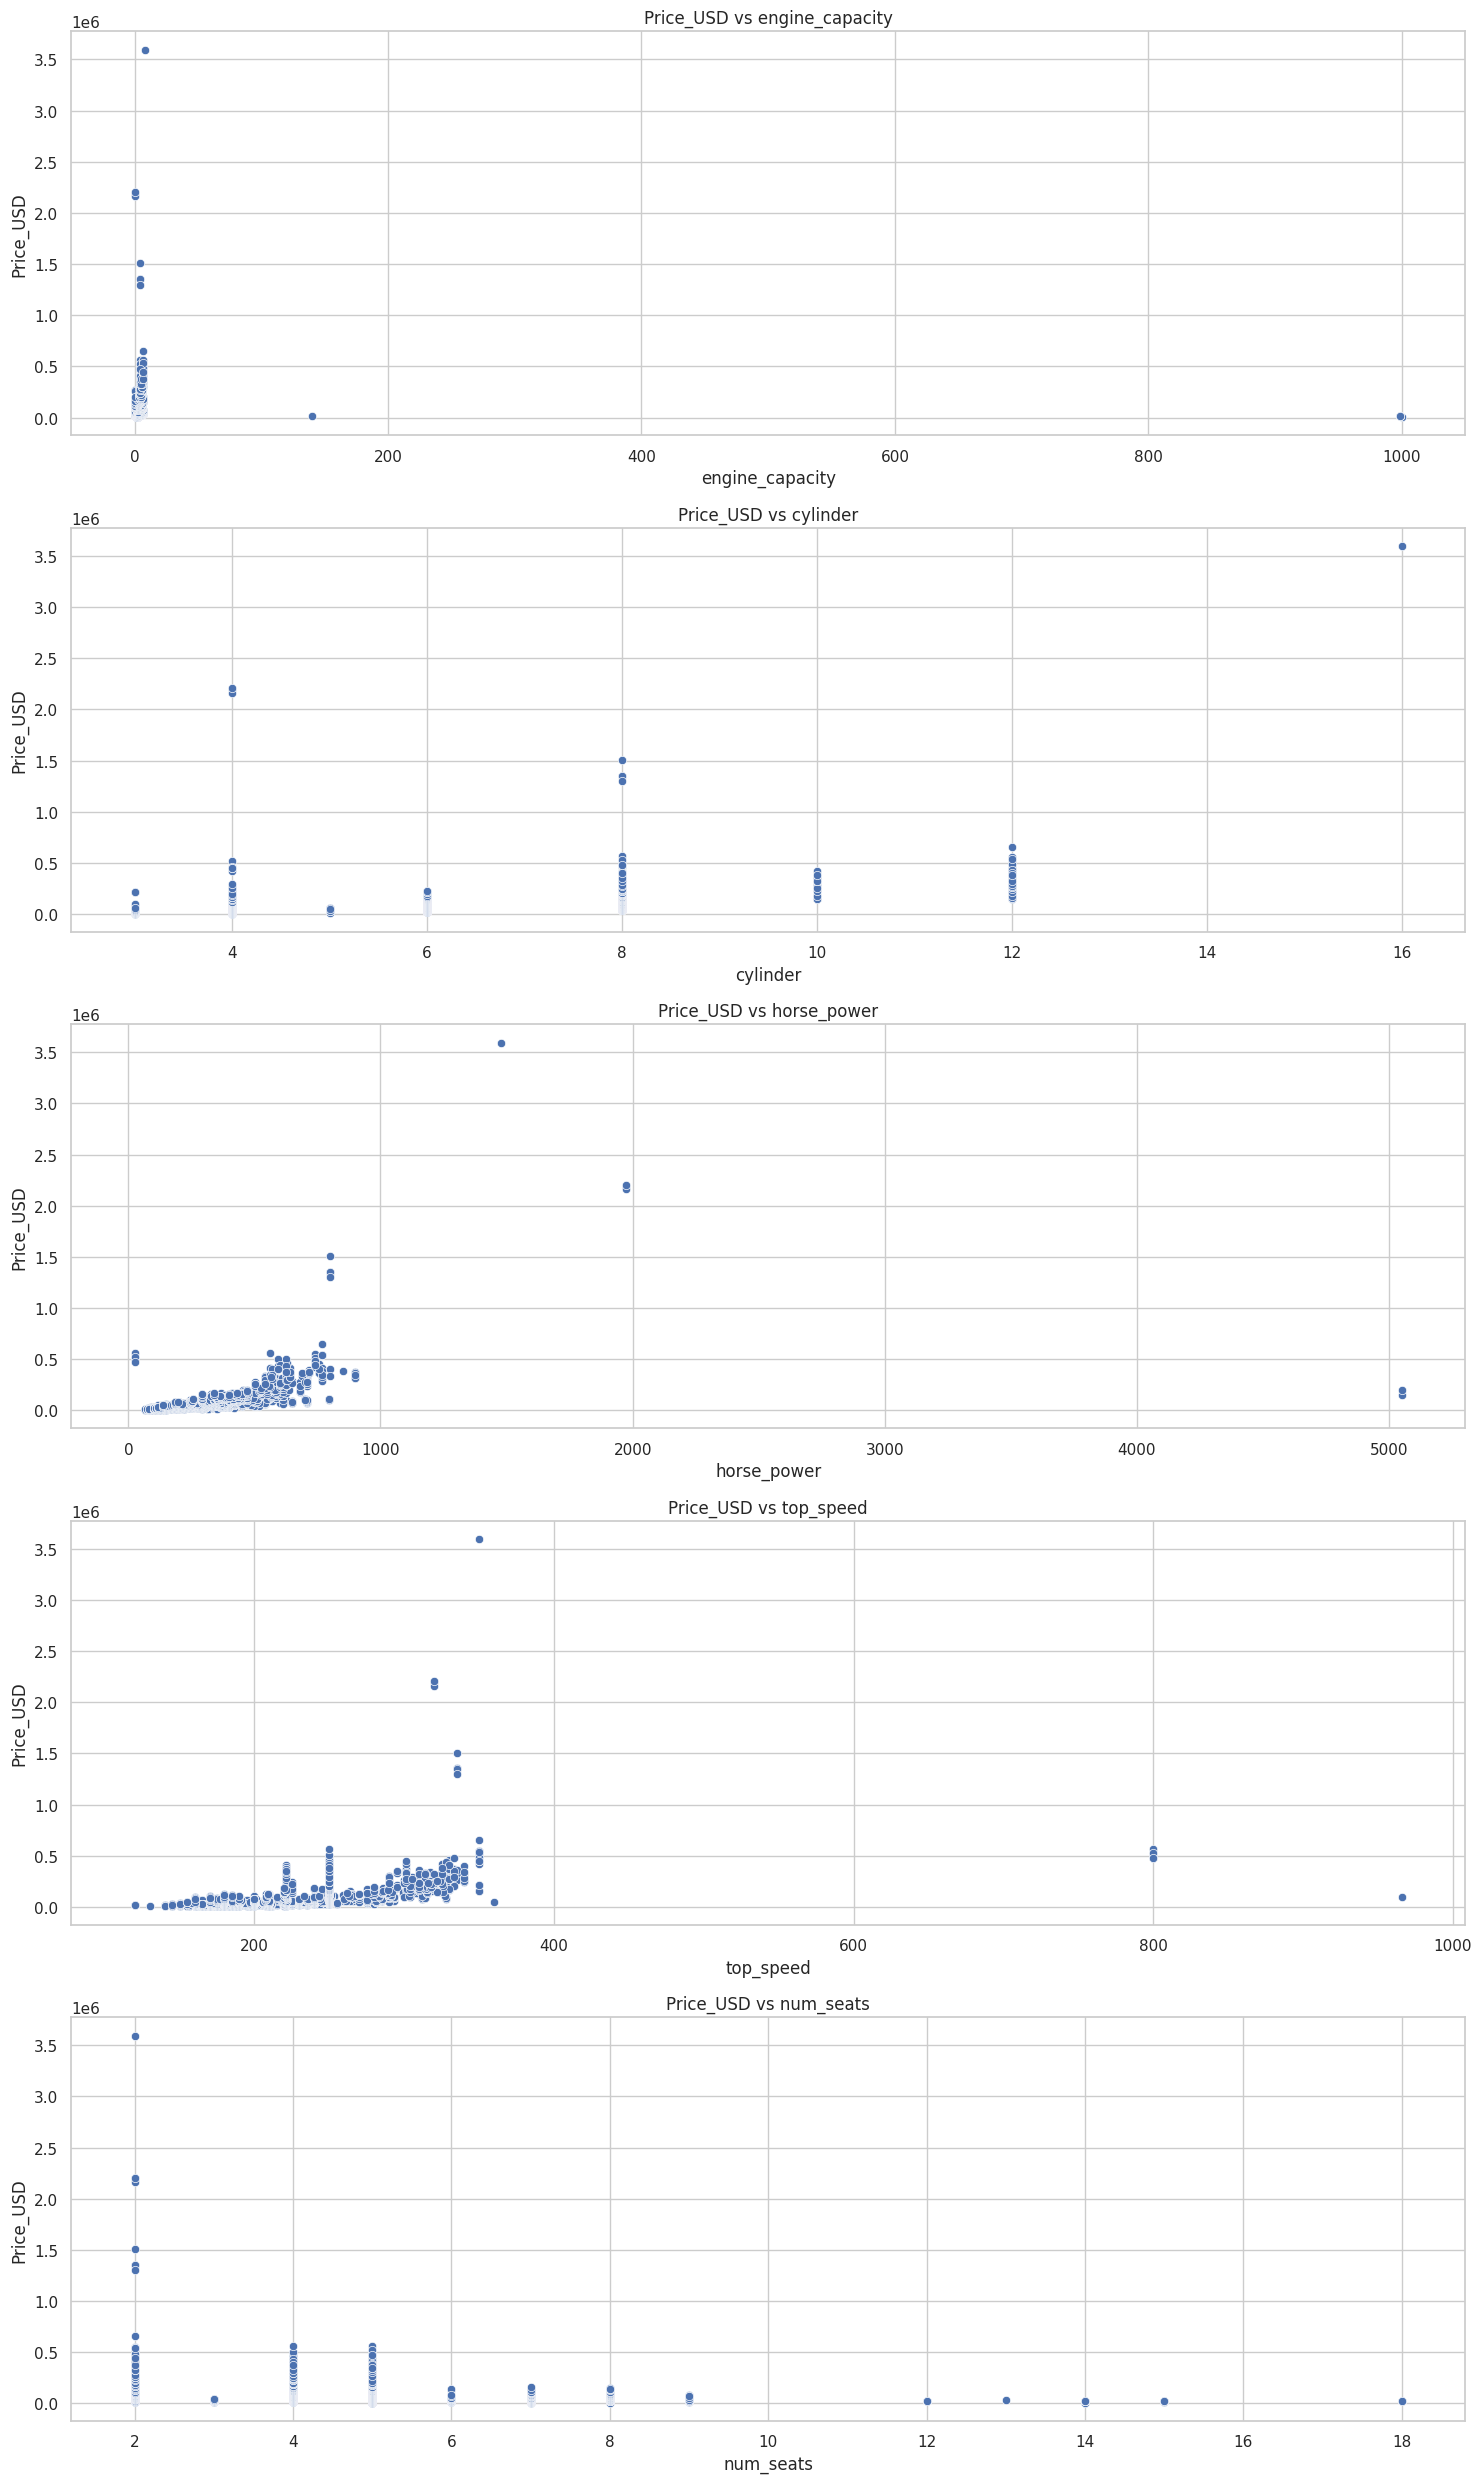

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


# Identify numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Remove 'Price_USD' from the list to use it as the dependent variable
numerical_columns.remove('Price_USD')

# Set up the plotting style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5 * len(numerical_columns)))

# Plot 'Price_USD' vs each numerical feature
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, i)
    sns.scatterplot(data=df, x=col, y='Price_USD')
    plt.title(f'Price_USD vs {col}')
    plt.xlabel(col)
    plt.ylabel('Price_USD')

plt.tight_layout()
plt.show()


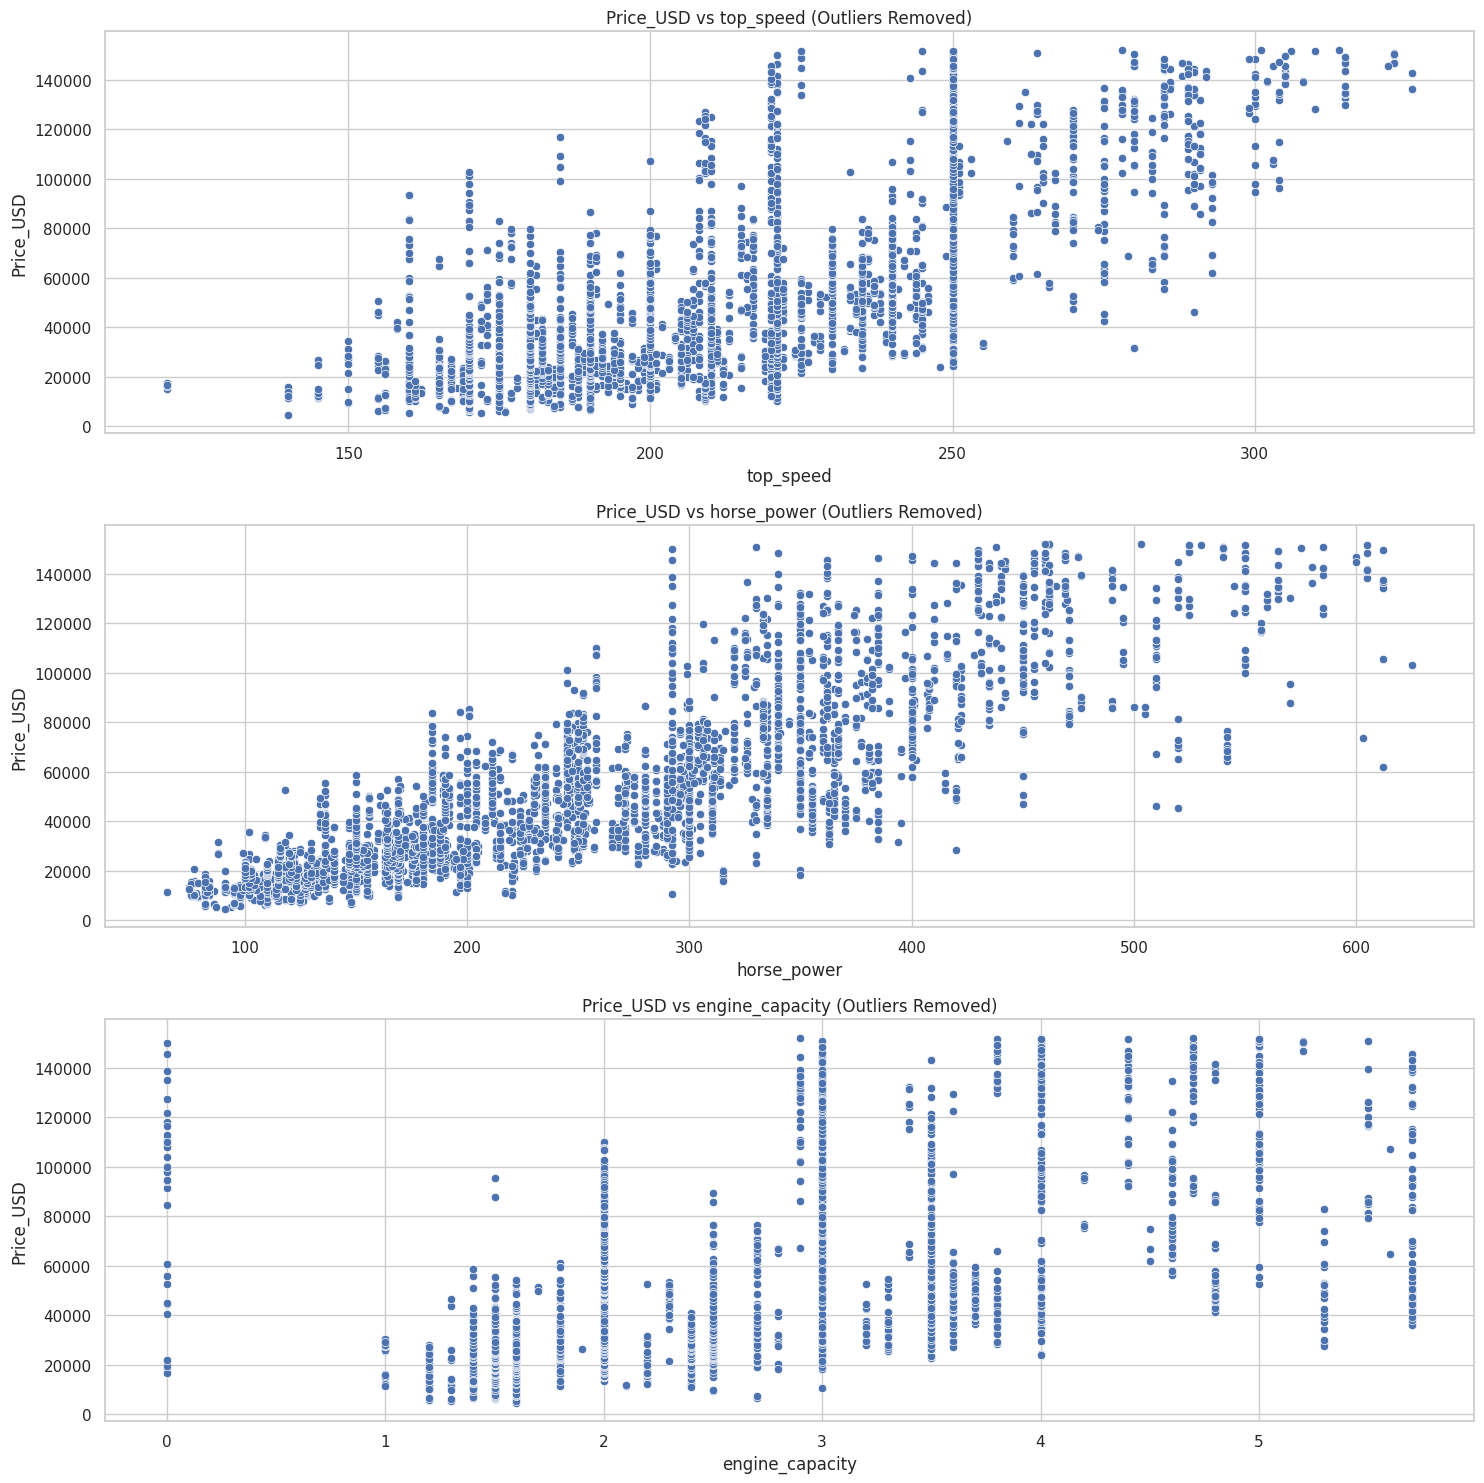

In [4]:
# Function to remove outliers based on IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


numerical_columns_to_remove_outliers = ['top_speed', 'horse_power', 'engine_capacity']

# Remove outliers from each numerical column
for col in numerical_columns_to_remove_outliers + ['Price_USD']:  # Include 'Price_USD' as well
    df = remove_outliers(df, col)

# Set up the plotting style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5 * len(numerical_columns_to_remove_outliers)))

# Plot 'Price_USD' vs each numerical feature without outliers
for i, col in enumerate(numerical_columns_to_remove_outliers, 1):
    plt.subplot(len(numerical_columns_to_remove_outliers), 1, i)
    sns.scatterplot(data=df, x=col, y='Price_USD')
    plt.title(f'Price_USD vs {col} (Outliers Removed)')
    plt.xlabel(col)
    plt.ylabel('Price_USD')

plt.tight_layout()
plt.show()
